In [51]:
#Importar paquetes
import pandas as pd
import numpy as np
import sqlite3 as sql
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from ipywidgets import interact

In [2]:
import os  ### para ver y cambiar directorio de trabajo

In [3]:
os.getcwd()

'c:\\Users\\Sergio\\Desktop\\AnaliticaIII-Marketing\\AnaliticaIII-Marketing'

In [4]:
###### para ejecutar sql y conectarse a bd ###

conn=sql.connect('db_movies')
cur=conn.cursor() ###para funciones que ejecutan sql en base de datos


In [5]:
def ejecutar_sql (nombre_archivo, cur):
    sql_file=open(nombre_archivo)
    sql_as_string=sql_file.read()
    sql_file.close
    cur.executescript(sql_as_string)

In [6]:
#######
############ cargar tablas ####

movies= pd.read_sql('select * from movies', conn)
ratings = pd.read_sql('select * from ratings', conn)

Tabla Movies

In [7]:
#Ver los primeros 5 datos de la tabla movies
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
#Observar columnas de movies
print('Columnas:',movies.columns)
#Dimensiones de la base
print('Dimensiones:', movies.shape)

Columnas: Index(['movieId', 'title', 'genres'], dtype='object')
Dimensiones: (9742, 3)


In [9]:
#Conocer el tipo de variables
print(movies.dtypes)

movieId     int64
title      object
genres     object
dtype: object


In [10]:
#Información general
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Tabla Ratings

In [11]:
#Ver primeros cinco datos de la tabla ratings
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [12]:
#Información general
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
#Observar columnas de movies
print('Columnas:',ratings.columns)
#Dimensiones de la base
print('Dimensiones:', ratings.shape)

Columnas: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Dimensiones: (100836, 4)


In [14]:
#Conocer el tipo de variables
print(ratings.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [15]:
#Ejemplo de cambio de formato de timestamp a datetime
from datetime import datetime
datetime.fromtimestamp(964982703)

datetime.datetime(2000, 7, 30, 13, 45, 3)

In [16]:
#Modificar formato de timestamp a datetime
from datetime import datetime
ratings['timestamp']= ratings.apply(lambda x: datetime.fromtimestamp(x['timestamp']), axis=1)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 13:45:03
1,1,3,4.0,2000-07-30 13:20:47
2,1,6,4.0,2000-07-30 13:37:04
3,1,47,5.0,2000-07-30 14:03:35
4,1,50,5.0,2000-07-30 13:48:51


Nueva base de datos

In [18]:
#Crear base de datos con la unión de las tablas de movies y ratings
movie_ratings = pd.merge(ratings,movies, how="left", right_on="movieId", left_on="movieId")
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2000-07-30 13:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,2000-07-30 13:20:47,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,2000-07-30 13:37:04,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,2000-07-30 14:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,2000-07-30 13:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [19]:
#Información general de la nueva base de datos
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
 4   title      100836 non-null  object        
 5   genres     100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 5.4+ MB


In [20]:
#Verificar si hay datos duplicados 
movie_ratings.duplicated().sum()

0

In [21]:
#Observar columnas de la nueva base de datos
movie_ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')

In [22]:
#Crear base de datos con variables dummies del campo genero 
genres = movies.copy()
genres = genres.drop(columns=['movieId', 'title'])
genres['genres'] = genres['genres'].str.split('|')
genres_dummies = pd.get_dummies(pd.DataFrame(genres['genres'].tolist()).stack()).sum(level=0)
genres = pd.concat([genres, genres_dummies], axis=1).drop(columns=['genres'])
genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
#Concatenar la base de datos movies con la base de datos de los generos de peliculas (dummies)
movies2 = pd.concat([movies, genres], axis=1)
movies2 = movies2.drop(['genres'], axis=1)
movies2.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#Base de datos con variables de movieid y title
movies3 = pd.melt(movies2, id_vars= ['movieId', 'title'])
print(movies3.columns)


Index(['movieId', 'title', 'variable', 'value'], dtype='object')


In [25]:
#Mostrar los primeros 10 datos de movies3
movies3.sample(10)

,movieId,title,variable,value
56500,91974,Underworld: Awakening (2012),Comedy,0
43836,7294,Welcome to Mooseport (2004),Children,0
51744,4062,Mystic Pizza (1988),Comedy,1
103292,33004,"Hitchhiker's Guide to the Galaxy, The (2005)",Film-Noir,0
142378,36850,Police Story 2 (Ging chaat goo si juk jaap) (1...,Mystery,0
146504,430,Calendar Girl (1993),Romance,0
18560,131098,Saving Santa (2013),Action,0
87683,6,Heat (1995),Fantasy,0
123091,44931,Secrets of a Soul (Geheimnisse einer Seele) (1...,IMAX,0
175669,355,"Flintstones, The (1994)",War,0


In [26]:
#Tabla con el valor de cada genero
movies3.groupby('variable')[['value']].sum().reset_index()

,variable,value
0,(no genres listed),34.0
1,Action,1828.0
2,Adventure,1263.0
3,Animation,611.0
4,Children,664.0
5,Comedy,3756.0
6,Crime,1199.0
7,Documentary,440.0
8,Drama,4361.0
9,Fantasy,779.0


In [27]:
#Juntas bases de datos de movies con dummies y ratings 
movie_ratings1 = pd.merge(ratings,movies2, how="left", right_on="movieId", left_on="movieId")
movie_ratings1

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-30 13:45:03,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-30 13:20:47,Grumpier Old Men (1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-30 13:37:04,Heat (1995),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,2000-07-30 14:03:35,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,2000-07-30 13:48:51,"Usual Suspects, The (1995)",0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 16:53:22,Split (2017),0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
100832,610,168248,5.0,2017-05-03 17:21:31,John Wick: Chapter Two (2017),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100833,610,168250,5.0,2017-05-08 14:50:47,Get Out (2017),0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
100834,610,168252,5.0,2017-05-03 16:19:12,Logan (2017),0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Anális Exploratorio

In [31]:
#Instalación de paquetes
pip install plotly
pip install nbformat

SyntaxError: invalid syntax (<ipython-input-31-37438a567280>, line 2)

In [32]:
#Importar paquetes
import plotly.graph_objs as go #Graficos
import plotly.express as px
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt ### gráficos

In [33]:
# crear dataset
base = movie_ratings.groupby(['title'])[['rating']].count().sort_values('rating', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.bar(base, x = 'title', y='rating',
             title= '<b>Películas más calificadas<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Películas',
    yaxis_title = 'Calificación',
    template = 'simple_white',
    title_x = 0.5)



(array([ 8791., 10332.,  8003.,  8822., 10673.,  8590., 11151., 12109.,
         6309., 16056.]),
 array([  1. ,  61.9, 122.8, 183.7, 244.6, 305.5, 366.4, 427.3, 488.2,
        549.1, 610. ]),
 <BarContainer object of 10 artists>)

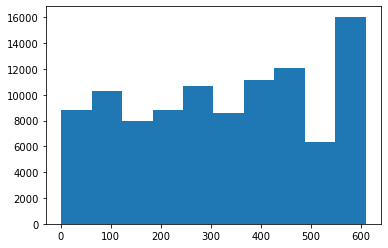

In [34]:
#Histograma
plt.hist(movie_ratings['userId'])

In [35]:
mr =  movie_ratings.groupby(['movieId','title','timestamp'])
mr

In [36]:
# ARREGLAR
# crear dataset
base = movies3.groupby(['variable'])[['value']].sum().sort_values('value', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.pie(base, values = 'value', names ='variable',
             title= '<b>Porcentaje de los 10 generos de películas más vistos <b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

In [161]:
#Crear dataset
final_dataset = movie_ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset = final_dataset.fillna(0)
final_dataset

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
#saber cuantas calificaciones tiene cada pelicula
no_user_voted = movie_ratings.groupby('movieId')['rating'].agg('count')
#saber cuantas veces han calificado cada película
no_movies_voted = movie_ratings.groupby('userId')['rating'].agg('count')


In [164]:
#Maximo de votaciones de peliculas
print(no_movies_voted.max())
#Minimo de votaciones de peliculas
print(no_movies_voted.min())

2698
20


In [165]:
#Imprimir el numero de votos minimo por usuario
print(no_user_voted.min())
#Imprimir el numero de votos maximo por usuario
print(no_user_voted.max())

1
329


<AxesSubplot:title={'center':'Ratings por usuario'}, ylabel='Ratings'>

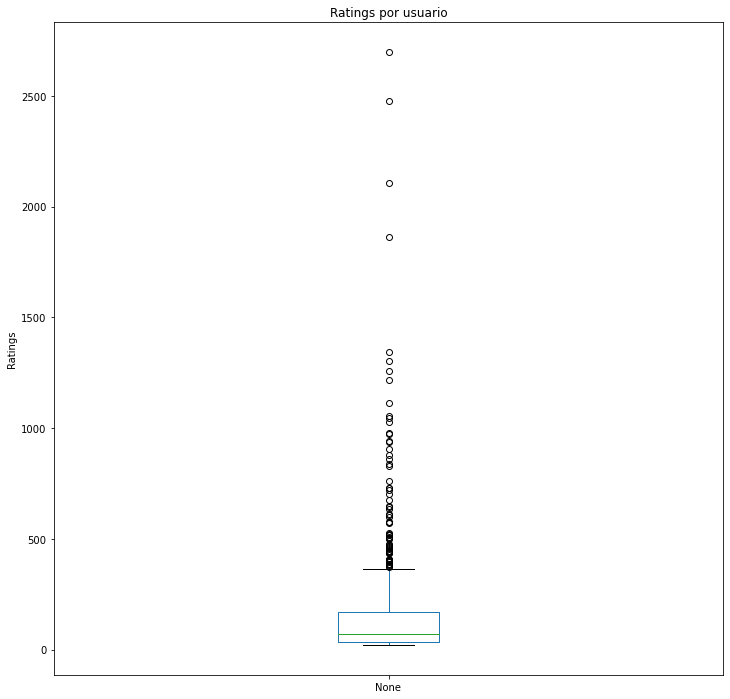

In [166]:
#Crear boxplot con ratings por usuarios
rated_movies_by_user = ratings.groupby("userId").size().sort_values(ascending=False)
rated_movies_by_user.plot.box(figsize=(12,12), ylabel="Ratings", title='Ratings por usuario')

In [167]:
#promedio de calificaciones por usuario
rated_movies_by_user = ratings.groupby("userId").size().count()
rated_movies_by_user

610

In [170]:
#Construir un dataset con los requisitos de votacion de los usuarios mayor a 10 y votacion de peliculas mayor a 100 
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 100].index]
final_dataset

userId,1,4,6,7,10,15,17,18,19,20,...,599,600,601,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,2.5,4.5,3.5,4.0,0.0,...,3.0,2.5,4.0,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,...,2.5,4.0,0.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,4.5,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [172]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [53]:
movie_name='Iron Man'

In [431]:
def get_movie_recommendation(Movie_id = list(movies['title'])):
    n_movies_to_reccomend = 10
    #movie_list = movies[movies['title'].str.contains(Movie_id)]  
    
    if len(Movie_id):
        Movie_id=movies[movies['title'].str.contains(Movie_id)]        
        movie_idx= Movie_id.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx =movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "No movies found. Please check your input"

In [435]:
get_movie_recommendation('Spider-Man')

,Title,Distance
1,Pirates of the Caribbean: The Curse of the Bla...,0.285845
2,Shrek (2001),0.282840
3,"Lord of the Rings: The Return of the King, The...",0.275932
4,"Bourne Identity, The (2002)",0.273384
5,X-Men (2000),0.271716
6,Star Wars: Episode II - Attack of the Clones (...,0.260246
7,Minority Report (2002),0.256223
8,"Lord of the Rings: The Two Towers, The (2002)",0.255674
9,"Lord of the Rings: The Fellowship of the Ring,...",0.243543
10,Spider-Man 2 (2004),0.232026


In [433]:
print(interact(get_movie_recommendation))

interactive(children=(Dropdown(description='Movie_id', options=('Toy Story (1995)', 'Jumanji (1995)', 'Grumpie…

<function get_movie_recommendation at 0x0000021AE959E790>


In [216]:
#Instalacion de paquetes
conda install -n notebook_env nb_conda_kernels
pip install -U ipykernel
conda install -c conda-forge scikit-surprise
pip install scikit-surprise

SyntaxError: invalid syntax (<ipython-input-216-81d7130f14ad>, line 2)

In [217]:
#Funciones del paquete surprise
from surprise import Reader, Dataset
#Escoger modeolos
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD
from surprise.model_selection import train_test_split

In [218]:
# leer datos desde tabla de pandas
reader = Reader(rating_scale=(0, 10))

In [232]:
cell=final_dataset['movieId']
cell

0            1
1            2
2            3
3            5
4            6
         ...  
2116    174055
2117    176371
2118    177765
2119    179819
2120    187593
Name: movieId, Length: 2121, dtype: int64

In [439]:
cell=pd.DataFrame(cell)
cell

,movieId
0,1
1,2
2,3
3,5
4,6
...,...
2116,174055
2117,176371
2118,177765
2119,179819


In [440]:
ratingssel = pd.merge(cell,movie_ratings, how="left", right_on="movieId", left_on="movieId")
ratingssel

,movieId,userId,rating,timestamp,title,genres
0,1,1,4.0,2000-07-30 13:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,5,4.0,1996-11-08 01:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,1,7,4.5,2005-01-25 01:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,1,15,2.5,2017-11-13 07:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,1,17,4.5,2011-05-18 00:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
79631,187593,331,4.0,2018-09-17 20:49:54,Deadpool 2 (2018),Action|Comedy|Sci-Fi
79632,187593,338,1.0,2018-06-27 20:14:25,Deadpool 2 (2018),Action|Comedy|Sci-Fi
79633,187593,380,3.0,2018-07-11 18:19:53,Deadpool 2 (2018),Action|Comedy|Sci-Fi
79634,187593,514,3.5,2018-09-16 21:18:46,Deadpool 2 (2018),Action|Comedy|Sci-Fi


In [441]:
ratingssel

,movieId,userId,rating,timestamp,title,genres
0,1,1,4.0,2000-07-30 13:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,5,4.0,1996-11-08 01:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,1,7,4.5,2005-01-25 01:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,1,15,2.5,2017-11-13 07:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,1,17,4.5,2011-05-18 00:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
79631,187593,331,4.0,2018-09-17 20:49:54,Deadpool 2 (2018),Action|Comedy|Sci-Fi
79632,187593,338,1.0,2018-06-27 20:14:25,Deadpool 2 (2018),Action|Comedy|Sci-Fi
79633,187593,380,3.0,2018-07-11 18:19:53,Deadpool 2 (2018),Action|Comedy|Sci-Fi
79634,187593,514,3.5,2018-09-16 21:18:46,Deadpool 2 (2018),Action|Comedy|Sci-Fi


In [442]:
#Descargar base de datos
data   = Dataset.load_from_df(ratingssel[['userId','movieId','rating']], reader)

In [444]:
#Funcion para el uso de todos los modelos y analizar cual se comporta mejor
models=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()] 
results = {}

for model in models:
 
    CV_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5, n_jobs=-1)  
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result



In [445]:
#Comportamiento de los modelos
performance_df = pd.DataFrame.from_dict(results).T
performance_df.sort_values(by='RMSE')
#El mejor es el KNNBaseline tiene el menor MAE y RMSE

,MAE,RMSE,fit_time,test_time
knns.KNNBaseline,0.642288,0.839809,1.224983,6.488148
knns.KNNWithZScore,0.647773,0.851688,0.712713,4.941125
knns.KNNWithMeans,0.653578,0.853966,0.567180,4.110435
knns.KNNBasic,0.694271,0.903656,0.570468,3.645839


In [225]:
#Se implemento el MSD y cosenos
#Minimo de neighbours para la prediccion
param_grid = { 'sim_options' : {'name': ['msd','cosine'], \
                                'min_support': [5], \
                                'user_based': [False, True]}
             }

In [226]:
#Funcion con GridSearchCV
gridsearchKNNBaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], \
                                      cv=2, n_jobs=2)
gridsearchKNNBaseline.fit(data)

In [228]:
#Puntajes
print(gridsearchKNNBaseline.best_params["rmse"])
print(gridsearchKNNBaseline.best_score["rmse"])

{'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': False}}
0.8917838012739142


In [229]:
#Realizar predicciones 
trainset = data.build_full_trainset()

In [230]:
#Definir parametros
sim_options       = {'name':'msd','min_support':5,'user_based':True}
#Se elige el modelo con los mejores resultados 
model = KNNBaseline(sim_options=sim_options)
#Modelo entrenado
model=model.fit(trainset)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [231]:
#Construir base de datos con usuarios y peliculas no vistas 
predset = trainset.build_anti_testset() 
predictions = model.test(predset) ### función muy pesada
#Crear base de datos con predicciones 
predictions_df = pd.DataFrame(predictions)
predictions_df

,uid,iid,r_ui,est,details
0,1,318,3.501557,5.121563,"{'actual_k': 40, 'was_impossible': False}"
1,1,1704,3.501557,4.878661,"{'actual_k': 40, 'was_impossible': False}"
2,1,6874,3.501557,4.717670,"{'actual_k': 40, 'was_impossible': False}"
3,1,8798,3.501557,4.535827,"{'actual_k': 40, 'was_impossible': False}"
4,1,46970,3.501557,4.048609,"{'actual_k': 27, 'was_impossible': False}"
...,...,...,...,...,...
5830799,610,7377,3.501557,3.964698,"{'actual_k': 1, 'was_impossible': False}"
5830800,610,8667,3.501557,3.964698,"{'actual_k': 1, 'was_impossible': False}"
5830801,610,32302,3.501557,4.464698,"{'actual_k': 1, 'was_impossible': False}"
5830802,610,51903,3.501557,2.964698,"{'actual_k': 1, 'was_impossible': False}"


In [305]:
#Función de recomendaciones 
def recomendaciones(user_id,n_recomend=10):
    
    predictions_userID = predictions_df[predictions_df['uid'] == user_id].\
                    sort_values(by="est", ascending = False).head(n_recomend)

    recomendados = predictions_userID[['iid','est']]
    recomendados.to_sql('reco',conn,if_exists="replace")
    
    recomendados=pd.read_sql('''select a.*,b.ratingssel 
                             from reco a left join books_final b
                             on a.iid=b.isbn ''', conn)

    return(recomendados)


In [249]:
np.set_printoptions(threshold=sys.maxsize)
predictions_df['uid'].unique()[:20] 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [306]:
us1=recomendaciones(user_id=9,n_recomend=20)
us1

DatabaseError: Execution failed on sql 'select a.*,b.ratingssel 
                             from reco a left join books_final b
                             on a.iid=b.isbn ': no such table: books_final

In [304]:
#######################################################################
#### Sistema de recomendación basado en contenido KNN #################
#### Con base en todo lo visto por el usuario #######################
#######################################################################



user_id=15

def recomendar(user_id=list(ratingssel['userId'].value_counts().index)):
    
    ratings=pd.read_sql('select *from ratingssel where user_id=:userId',conn, params={'userId':user_id})
    l_books_r=ratings['isbn'].to_numpy()
    books_dum2[['isbn','book_title']]=books[['isbn','book_title']]
    books_r=books_dum2[books_dum2['isbn'].isin(l_books_r)]
    books_r=books_r.drop(columns=['isbn','book_title'])
    books_r["indice"]=1 ### para usar group by y que quede en formato pandas tabla de centroide
    centroide=books_r.groupby("indice").mean()
    
    
    books_nr=books_dum2[~books_dum2['isbn'].isin(l_books_r)]
    books_nr=books_nr.drop(columns=['isbn','book_title'])
    model=neighbors.NearestNeighbors(n_neighbors=11, metric='cosine')
    model.fit(books_nr)
    dist, idlist = model.kneighbors(centroide)
    
    ids=idlist[0]
    recomend_b=books.loc[ids][['book_title','isbn']]
    leidos=books[books['isbn'].isin(l_books_r)][['book_title','isbn']]
    
    return recomend_b

recomendar(52853)


print(interact(recomendar))

DatabaseError: Execution failed on sql 'select *from ratingssel where user_id=:userId': no such table: ratingssel